## Diagnóstico médico baseado em relatos de pacientes

O objetivo deste modelo de diagnóstico é classificar relatos textuais de pacientes sobre seus sintomas entre 4 classes distintas no contexto de doenças cardíacas, sendo elas:

- Infarto.
- Insuficiência Cardíaca.
- Angina.
- Arritmia.

### Instalação e importação das bibliotecas

In [1]:
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     --------------- ------------------------ 5.0/13.0 MB 27.4 MB/s eta 0:00:01
     --------------------------------------- 13.0/13.0 MB 37.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from joblib import dump

SEED = 654

pln = spacy.load('pt_core_news_sm')

### Carregamento do dataset

In [3]:
df = pd.read_csv('../dataset/sintomas_doencas_cardiacas.csv')
df.head()

,frase,diagnostico,risco
0,Sinto uma dor aguda no peito que surge ao subi...,Angina,Baixo Risco
1,"Há dois dias, dor forte no peito irradia para ...",Infarto,Alto Risco
2,"Estou exausto o dia todo, mesmo sem esforço, e...",Insuficiência Cardíaca,Baixo Risco
3,Meu coração acelera de repente durante reuniõe...,Arritmia,Alto Risco
4,"Pressão no peito ao estressar no trabalho, ali...",Angina,Baixo Risco


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   frase        100 non-null    object
 1   diagnostico  100 non-null    object
 2   risco        100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


Text(0, 0.5, 'Contagem')

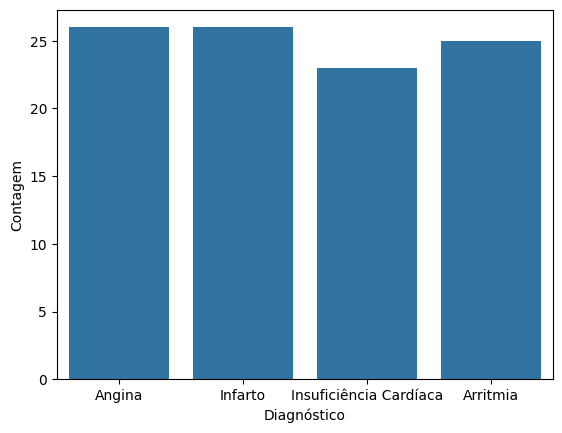

In [5]:
sns.countplot(df, x='diagnostico')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')

### Pré-processamento dos dados textuais

In [6]:
def text_processing(txt: str):
    """_summary_

    Args:
        txt (str): Texto a ser processado
        
    - Normaliza para minúsculas.
    - Remove stopwords, pontuações, acentuações e digítos numéricos.
    - Padroniza as palavras com a Lematização.
    """
    txt = txt.lower()
    doc = pln(txt)
    
    words: list[str] = []
    
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            words.append(token.lemma_)
    
    words = ' '.join(unidecode(word) for word in words)
    return words

In [7]:
df['frase_processada'] = df['frase'].apply(text_processing)
df.head()

,frase,diagnostico,risco,frase_processada
0,Sinto uma dor aguda no peito que surge ao subi...,Angina,Baixo Risco,sinto dor aguda peito surgir subir escar durar...
1,"Há dois dias, dor forte no peito irradia para ...",Infarto,Alto Risco,haver dia dor forte peito irradir braco esquer...
2,"Estou exausto o dia todo, mesmo sem esforço, e...",Insuficiência Cardíaca,Baixo Risco,exausto dia esforco incho pe noite
3,Meu coração acelera de repente durante reuniõe...,Arritmia,Alto Risco,coracao acelerar repente durante reuniao sensa...
4,"Pressão no peito ao estressar no trabalho, ali...",Angina,Baixo Risco,pressao peito estressar trabalho aliviar sentar


Realizado estratificação dos dados (equilibrar os rótulos entre treino e teste) para melhorar o desempenho do modelo. Porém, pelo fato da pouca quantidade de dados e também pelo número de classes (4) foi necessário aumentar o tamanho do dataset de teste para 40% do total.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['frase_processada'], df['diagnostico'], stratify=df['diagnostico'], random_state=SEED)

### Treinamento de alguns modelos de classificação

**Pipeline com Tokenização das frases com TF-IDF e Ngrams**

A pipeline transforma os dados textuais em um vetor chamada de *Bolsa de Palavras (Bag of Words - Bow)*, define as propriedades *lowercase* como false pois já é realizado a normalização dos textos em minúsculas e a propriedade *ngram_range* gerá palavras individuais e bigramas.

In [9]:
labels = np.unique(df['diagnostico'])

**Regressão Logística**

In [10]:
lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=False, max_features=1000, ngram_range=(1,2))),
    ('estimator', LogisticRegression())
])

lr_pipeline.fit(X_train, y_train)

lr_model_acc = lr_pipeline.score(X_test, y_test)
print(f'Acurácia do modelo: {lr_model_acc*100:.2f}%')

Acurácia do modelo: 92.00%


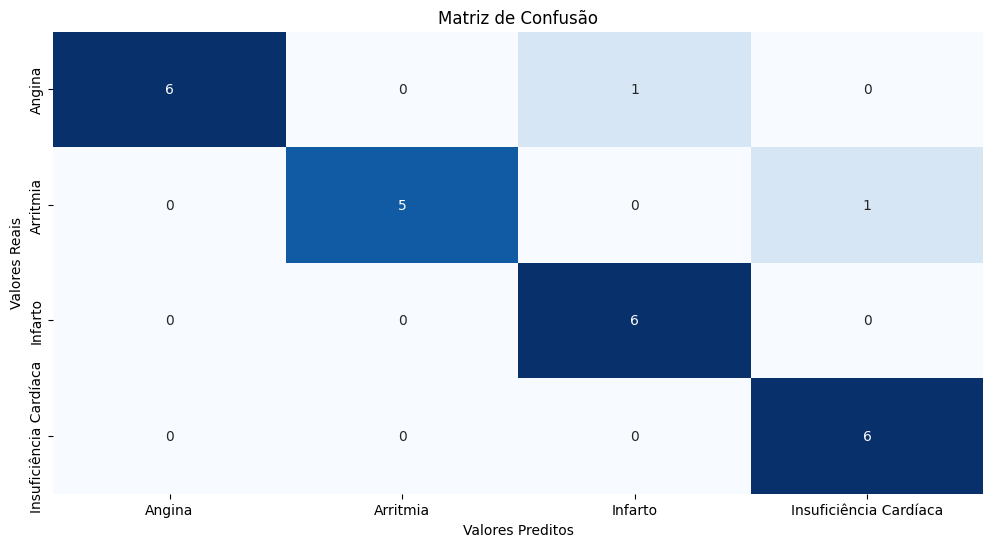

In [11]:
predicts_lr = lr_pipeline.predict(X_test)

cm_lr = confusion_matrix(y_test, predicts_lr)

plt.figure(figsize=(12,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

In [12]:
print(classification_report(y_test, predicts_lr, zero_division=False))

                        precision    recall  f1-score   support

                Angina       1.00      0.86      0.92         7
              Arritmia       1.00      0.83      0.91         6
               Infarto       0.86      1.00      0.92         6
Insuficiência Cardíaca       0.86      1.00      0.92         6

              accuracy                           0.92        25
             macro avg       0.93      0.92      0.92        25
          weighted avg       0.93      0.92      0.92        25



**Floresta Aleatória**

In [13]:
rf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=False, max_features=1000, ngram_range=(1,2))),
    ('estimator', RandomForestClassifier(random_state=SEED))
])

rf_pipeline.fit(X_train, y_train)

rf_model_acc = rf_pipeline.score(X_test, y_test)
print(f'Acurácia do modelo: {rf_model_acc*100:.2f}%')

Acurácia do modelo: 80.00%


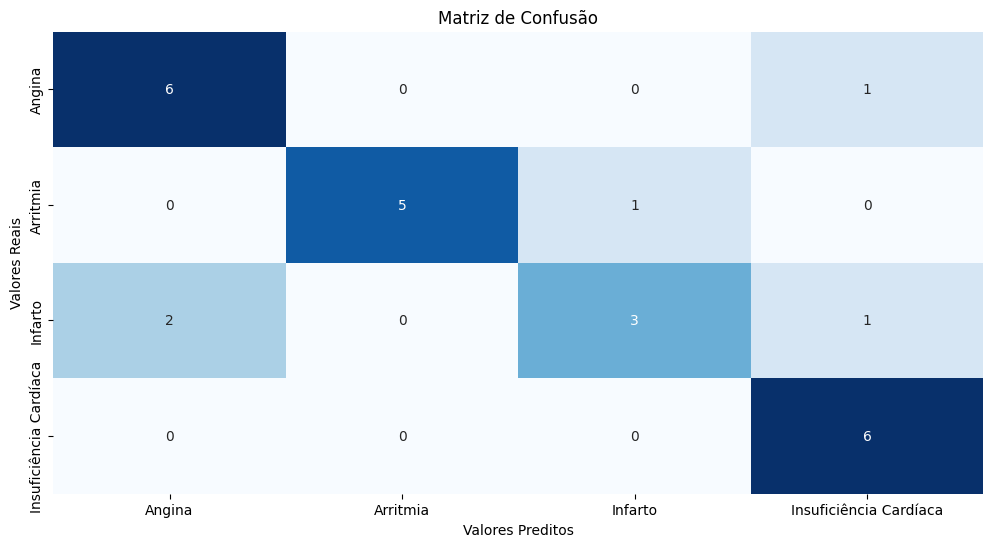

In [14]:
predicts_rf = rf_pipeline.predict(X_test)

cm_rf = confusion_matrix(y_test, predicts_rf)

plt.figure(figsize=(12,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

In [15]:
print(classification_report(y_test, predicts_lr, zero_division=False))

                        precision    recall  f1-score   support

                Angina       1.00      0.86      0.92         7
              Arritmia       1.00      0.83      0.91         6
               Infarto       0.86      1.00      0.92         6
Insuficiência Cardíaca       0.86      1.00      0.92         6

              accuracy                           0.92        25
             macro avg       0.93      0.92      0.92        25
          weighted avg       0.93      0.92      0.92        25



### Testes com frases

In [16]:
texts = [
    'estou sentindo uma dor forte no peito',
    'sinto um cansaço extremo mesmo descansado',
    'as vezes sinto meu coração falhar',
    'sinto um estranho aperto no peito com pouco esforço'
]

In [17]:
predicts = lr_pipeline.predict(texts)
predicts

array(['Infarto', 'Insuficiência Cardíaca', 'Arritmia', 'Angina'],
      dtype=object)

**Exportação do melhor modelo (Regressão Logística)**

In [18]:
dump(lr_pipeline, 'modelo_diagnostico_lr_pipeline.joblib')

['modelo_diagnostico_lr_pipeline.joblib']

## Conclusão

Pelo fato de termos gerado as frases de sintomas de pacientes de forma sintética é possível que a pontuação adquirida não reflita a realidade, seja por algum tipo enviesamento, seja pela ausência de uma revisão geral em todas as frases geradas, por isso, não é uma base de dados recomendada para utilizar em ambientes de produção. Porém, o fluxo do algoritmo pode ser reutilizado para diversos contextos além de problemas médicos, pois o processo que fizemos de pré-processamento e tokenização com a estratégia da lematização é genérico, assim como, o processo de treinamento e teste do modelo também poderiam ser reutilizados para outros problemas.